# AIPI 590 - XAI | Assignment #2
### Interpretable ML
### Kayla Haeussler

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khaeuss808/AIPI590_InterpretableAI/blob/main/Assignment1.ipynb)

In [248]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI590_InterpretableAI" # Change to your repo name
git_path = 'https://github.com/khaeuss808/AIPI590_InterpretableAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = ''
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: ./sample_data: No such file or directory
Cloning into 'AIPI590_InterpretableAI'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 38 (delta 19), reused 29 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 505.02 KiB | 7.65 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/Users/kaylahaeusssler/.Trash/AIPI590_InterpretableAI 01-31-11-107/AIPI590_InterpretableAI/AIPI590_InterpretableAI
Assignment1.ipynb                     WA_Fn-UseC_-Telco-Customer-Churn.csv
README.md


In [249]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    roc_curve,
    log_loss,
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from pygam import LogisticGAM

In [250]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# (1) Exploratory Data Analysis

> Will begin by encoding Churn as 0 and 1, as opposed to current state of Yes and No

In [251]:
print(df.shape)

# Y var
df["Churn"] = [1 if x == "Yes" else 0 for x in df["Churn"]]

(7043, 21)


In [252]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

> TotalCharges is of type object, but should be numeric. Converting below and also removing the 11 rows that resulted in NaNs

In [253]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df[df["TotalCharges"].isna()]
df = df.dropna(subset=["TotalCharges"])

> Encoding categorical variables as is necessary for our future models

In [254]:
# customerID does not contribute value to the model as it is just a unique
#       identifier for customers, so I am dropping that col
df = df.drop(columns=["customerID"])
df_log = df.copy()  # for use in question 3, logistic regression
df_encoded = pd.get_dummies(df, drop_first=True, dtype=float)
print(df_encoded.shape)

(7032, 31)


> Splitting our data into features and output variable, and then splitting into training and test set for use in the following models

In [255]:
X = df_encoded.drop(columns=["Churn"])
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

> In the assingment description, this question also asks us to check that assumptions are met for each of the following models. Since assessing the assumptions in most cases requires first fitting the model, I check assumptions after fitting the models in each of the corresponding sections

# (2) Linear Regression

Linear Regression holds the following assumptions (as listed in class slides)
* Linearity
* Independence
* Homoscedasticity
* Normality of Residuals
* No Multicolinearity
* No Autocorrelation

After fitting my Linear Regression model below, I then evaluate if these assumptions are uphelp. I list the name of the assumption and then the corresponding plot/test in an md box.

> Below are evaluate model and residual plotting functions contained in Dr. Bent's notebook regression-interpretability.ipynb on the course GitHub

In [256]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X.columns, model.coef_):
        print(f"{feature}: {coef:.4f}")

    return model, y_pred

> I fit and evulate the Linear Regression model below, using the evaluate_model function defined above

In [257]:
lr_model, lr_pred = evaluate_model(
    LinearRegression(),
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    "Linear Regression",
)


Linear Regression:
MSE: 0.15
R2 Score: 0.25
SeniorCitizen: 0.0202
tenure: -0.0457
MonthlyCharges: -0.1148
TotalCharges: -0.1027
gender_Male: -0.0020
Partner_Yes: 0.0030
Dependents_Yes: -0.0136
PhoneService_Yes: -2133988019157.3552
MultipleLines_No phone service: -2133988019157.3723
MultipleLines_Yes: 0.0338
InternetService_Fiber optic: 0.1369
InternetService_No: 16147618113.8543
OnlineSecurity_No internet service: 21311191231.9392
OnlineSecurity_Yes: -0.0165
OnlineBackup_No internet service: -8641580005.2461
OnlineBackup_Yes: 0.0038
DeviceProtection_No internet service: -8363047774.1762
DeviceProtection_Yes: 0.0106
TechSupport_No internet service: -4584984889.5645
TechSupport_Yes: -0.0169
StreamingTV_No internet service: -7950635862.7559
StreamingTV_Yes: 0.0453
StreamingMovies_No internet service: -7918560814.1482
StreamingMovies_Yes: 0.0472
Contract_One year: -0.0478
Contract_Two year: -0.0318
PaperlessBilling_Yes: 0.0174
PaymentMethod_Credit card (automatic): -0.0044
PaymentMethod_E

> Assessing Accuracy: R-squared is pretty low, only 25% of the variation in Churn is explained by this model.  
 Linear regression is difficult to interpret in a classification setting like this (Churn/no Churn). Typically, we interpret coefficients in linear regression by how they increase/decrease the continuous outcome variable, but because the outcome variable is not continouos in this case, Linear regression is not a great choice (as we see when assumptions are assessed below) and it is difficult to interpret the coefficients. An example interpretation of the coefficients could be we expect Churn to go up by 0.0201 units when the customer is a senior citizen, but again because Churn is a binary outcome, this modeling doesnt really make sense.

### Linearity & Homoscedasticity: Residuals vs Fitted Plot

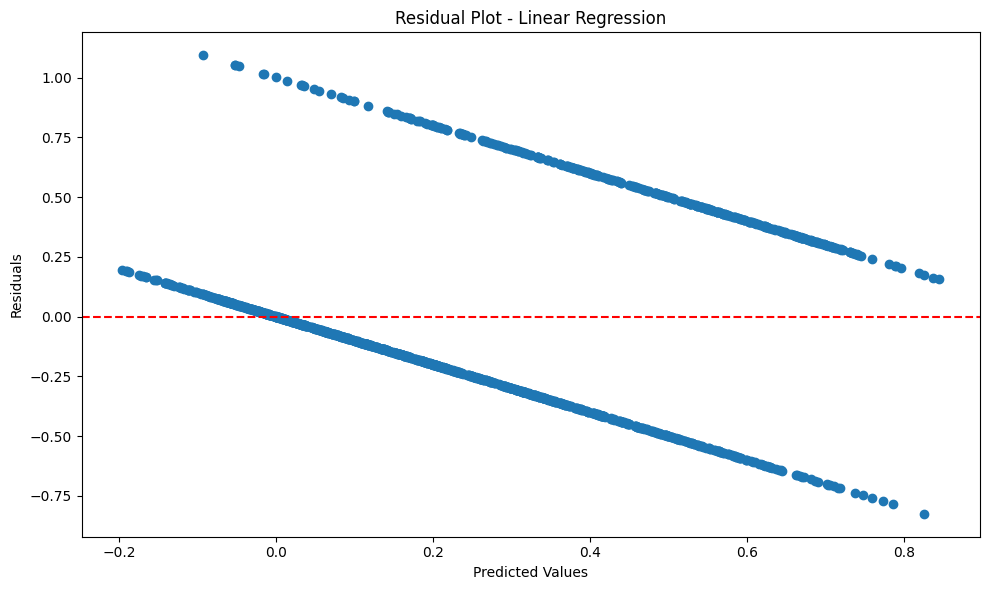

In [258]:
# Residual Plot: from Dr. Bent's notebook
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {model_name}")
    plt.axhline(y=0, color="r", linestyle="--")
    plt.tight_layout()
    plt.show()


plot_residuals(y_test, lr_pred, "Linear Regression")

> The above plot shows two strong lines, not a random cloud pattern, which tells us the linearity assumption is violated. The two strong lines also have variance that changes with the fitted values (diagonalness) which tells us that homoscedasticity is violated

### Normality of Residuals: QQ Plot

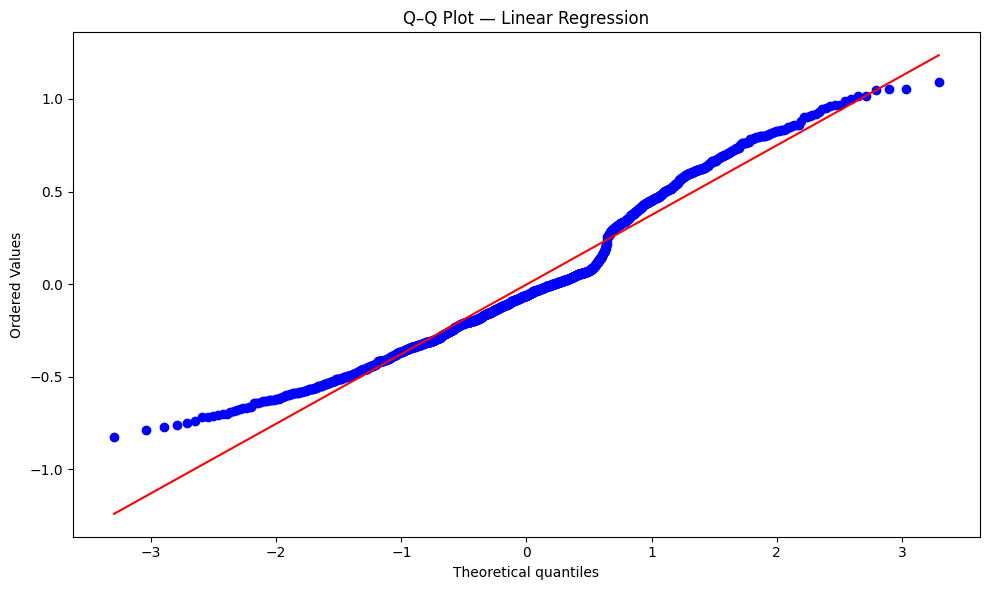

In [259]:
residuals = y_test - lr_pred
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title(f"Q–Q Plot — Linear Regression")
plt.tight_layout()
plt.show()

> The above plot shows variation from the diagonal (S shape) which tells us residuals are not normal and this assumption is violated.

### Multicollinearity: VIF

In [260]:
# appropriate to add constant for VIF
Xv = sm.add_constant(X_train, has_constant="add")  # add intercept


vif = pd.DataFrame(
    {
        "feature": Xv.columns[1:],  # skip intercept
        "VIF": [variance_inflation_factor(Xv.values, i) for i in range(1, Xv.shape[1])],
    }
).sort_values("VIF", ascending=False)

# print(vif)
# only printing those that are particularly concerning >5
print("\nVIF > 5:\n", vif[vif["VIF"] > 5])


VIF > 5:
                                  feature         VIF
11                    InternetService_No         inf
12    OnlineSecurity_No internet service         inf
20       StreamingTV_No internet service         inf
18       TechSupport_No internet service         inf
16  DeviceProtection_No internet service         inf
7                       PhoneService_Yes         inf
8         MultipleLines_No phone service         inf
14      OnlineBackup_No internet service         inf
22   StreamingMovies_No internet service         inf
2                         MonthlyCharges  875.944051
10           InternetService_Fiber optic  149.302028
23                   StreamingMovies_Yes   24.332467
21                       StreamingTV_Yes   24.176885
3                           TotalCharges   10.667213
1                                 tenure    7.475610
9                      MultipleLines_Yes    7.316372
17                  DeviceProtection_Yes    6.896485
15                      OnlineBacku

/Users/kaylahaeusssler/miniforge3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


> The VIF results show pretty severe multicollinearity (VIF>5). Specifically in those of the No Internet Service Levle. This is due to collinearity with the InternetService and PhoneService variables. I explore this further in logistic regression

### Autocorrelation: Durbin Watson Test

In [261]:
# I asked chatGPT how to perform a durbin watson test for autocorrelation and it yielded the following code
resid_train = y_train - lr_model.predict(X_train)
dw = durbin_watson(resid_train)

print(f"Durbin–Watson: {dw:.3f}")

Durbin–Watson: 0.000


/Users/kaylahaeusssler/miniforge3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


> The result of the DW test being around 2 tells us that there is no autocorrelation and that this assumption is upheld

Our linear regression model failed many of the assumptions of an LR model. This result is not surprising to me as linear regression is best used to predict a continuous outcome, and in this case we were using it to predict a binary outcome.

# (3) Logistic Regression
Logistic Regression holds the following assumptions (as listed in class slides)
* Linearity
* No Multicolinearity
* Independence of observations
* No influential outliers
* Absence of perfect separation
* Large Sample Size

After fitting my Logistic Regression model below, I then evaluate if these assumptions are uphelp. I list the name of the assumption and then the corresponding plot/test in an md box.
Pivoting away from using sklearn's functionality as Dr. Bent had in the functions of her's I was using for linear regression as I was encountering friction, switching to stat models as I am a little more comfortable

In [262]:
# documentation says that with statmodels one must manually add a constant, so doing that here
X_train_c = sm.add_constant(X_train, has_constant="add")
X_test_c = sm.add_constant(X_test, has_constant="add")

# logit_res = sm.Logit(y_train, X_train_c).fit()

> When I originally tried to fit my model above I was getting an error saying my design matrix had perfect collinearity. After some digging, I believe this is because there are multiple columns with the level no internet service which are equal to the InternetService and PhoneService column (issue is also seen in VIF of linear regression). In order to continue with the logistic regression, I am converting these levels in the columns of concern to also be "No"

In [263]:
# columns with the "no internet service" level
svc_cols = [
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]
# changing to no
df_log[svc_cols] = df_log[svc_cols].replace({"No internet service": "No"})
df_log["MultipleLines"] = df_log["MultipleLines"].replace({"No phone service": "No"})

# re encoding now that that issue is hopefully fixed
df_encoded = pd.get_dummies(df_log, drop_first=True, dtype=float)

# replitting X and y
X = df_encoded.drop(columns=["Churn"])
y = df_encoded["Churn"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# adding the contstants again
X_train_c = sm.add_constant(X_train, has_constant="add")
X_test_c = sm.add_constant(X_test, has_constant="add")
logit_res = sm.Logit(y_train, X_train_c).fit()

logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.410277
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 5625
Model:                          Logit   Df Residuals:                     5601
Method:                           MLE   Df Model:                           23
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.2914
Time:                        10:59:20   Log-Likelihood:                -2307.8
converged:                       True   LL-Null:                       -3257.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     1.7158      0.924      1.858      0.063      -0.094       3.526
SeniorCitizen                             0.2597      0.095      2.726      0.006       0.073       0.447
tenure                                   -0.0616      0.007     -8.735      0.000      -0.075      -0.048
MonthlyCharges                           -0.0608      0.036     -1.691      0.091      -0.131       0.010
TotalCharges                              0.0003   7.97e-05      4.221      0.000       0.000       0.000
gender_Male                              -0.0302      0.073     -0.414      0.679      -0.173       0.113
Partner_Yes                               0.0504      0.088      0.574      0.566      -0.122       0.222
Dependents_Yes                           -0.2155      0.102     -2.121      0.034      -0.415      -0.016
PhoneService_Yes                          0.5807      0.734      0.791      0.429      -0.857       2.019
MultipleLines_Yes                         0.5235      0.201      2.606      0.009       0.130       0.917
InternetService_Fiber optic               2.2956      0.904      2.541      0.011       0.525       4.067
InternetService_No                       -2.2454      0.913     -2.460      0.014      -4.034      -0.457
OnlineSecurity_Yes                       -0.1484      0.202     -0.735      0.462      -0.544       0.247
OnlineBackup_Yes                          0.1759      0.198      0.887      0.375      -0.213       0.565
DeviceProtection_Yes                      0.2782      0.198      1.402      0.161      -0.111       0.667
TechSupport_Yes                          -0.1194      0.204     -0.585      0.559      -0.520       0.281
StreamingTV_Yes                           0.8290      0.369      2.247      0.025       0.106       1.552
StreamingMovies_Yes                       0.8488      0.370      2.294      0.022       0.123       1.574
Contract_One year                        -0.7698      0.123     -6.268      0.000      -1.010      -0.529
Contract_Two year                        -1.3444      0.196     -6.864      0.000      -1.728      -0.961
PaperlessBilling_Yes                      0.2724      0.083      3.267      0.001       0.109       0.436
PaymentMethod_Credit card (automatic)    -0.1410      0.129     -1.095      0.274      -0.393       0.111
PaymentMethod_Electronic check            0.2600      0.106      2.444      0.015       0.051       0.469
PaymentMethod_Mailed check               -0.0714      0.128     -0.557      0.578      -0.323       0.180
=========================================================================================================
"""

> Logistic regression is much better suited to binary classification than linear regression, so interpreting the coefficients is possible here. There are many significant features (pvalue >0.05), we can interpret these as those who effect the odds with significance, from their reference level in the case of categorical variables. Each coefficient represents a change in log-odds. We can interpret the significant coefficients as follows:  
* SeniorCitizen: seniors have about 30% higher odds of churn than non-seniors (odds ratio ≈ 1.30).
* tenure: each +1 month reduces churn odds by ~6% (odds ratio ≈ 0.94); roughly 52% lower per year (odds ratio ≈ 0.48).
* TotalCharges: about 3% higher churn odds per $100 increase (odds ratio ≈ 1.03; note overlap with tenure/MonthlyCharges).
* Dependents_Yes: customers with dependents have ~19% lower odds (odds ratio ≈ 0.81).
* MultipleLines_Yes: having multiple lines is linked to ~69% higher odds (odds ratio ≈ 1.69).
* InternetService_Fiber optic: ~10× higher odds vs DSL (odds ratio ≈ 9.9).
* InternetService_No: ~89% lower odds vs DSL (odds ratio ≈ 0.11).
* StreamingTV_Yes: ~129% higher odds (odds ratio ≈ 2.29).
* StreamingMovies_Yes: ~134% higher odds (odds ratio ≈ 2.34).
* Contract_One year: ~54% lower odds vs month-to-month (odds ratio ≈ 0.46).
* Contract_Two year: ~74% lower odds vs month-to-month (odds ratio ≈ 0.26).
* PaperlessBilling_Yes: ~31% higher odds (odds ratio ≈ 1.31).
* PaymentMethod_Electronic check: ~30% higher odds vs bank transfer (auto) (odds ratio ≈ 1.30).

> The interpretation of these coefficients makes more sense and is more relevant to our core problem of interest than linear regression

### Assessing Accuracy

Accuracy: 0.788 | Precision: 0.623 | Recall: 0.516 | F1: 0.564
ROC AUC: 0.832 | LogLoss: 0.432 
              precision    recall  f1-score   support

           0      0.835     0.887     0.860      1033
           1      0.623     0.516     0.564       374

    accuracy                          0.788      1407
   macro avg      0.729     0.701     0.712      1407
weighted avg      0.779     0.788     0.781      1407



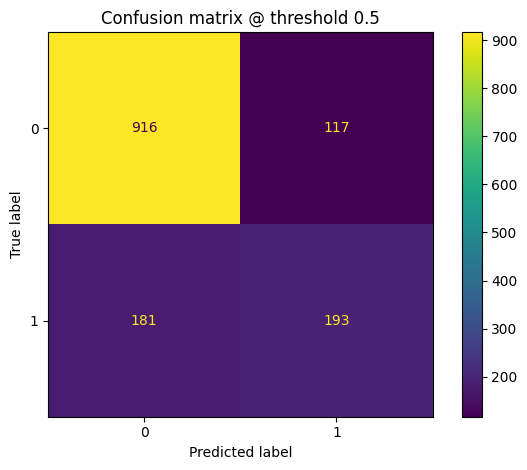

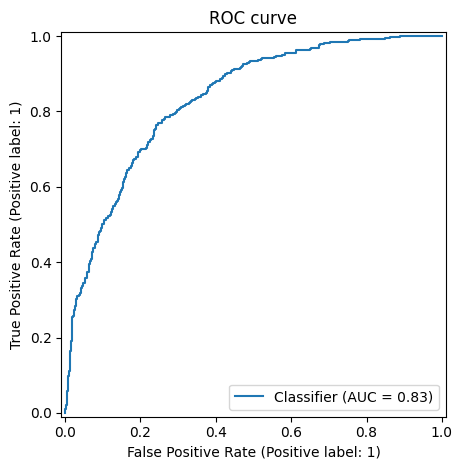

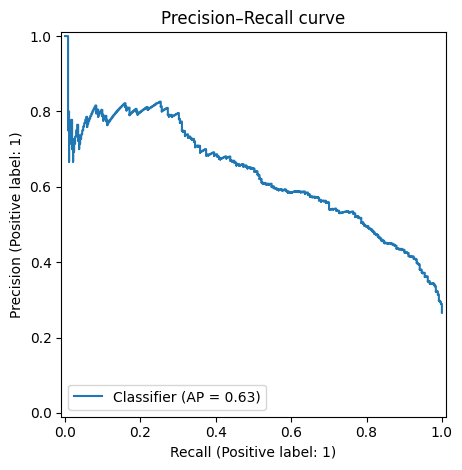

In [264]:
# Assessing Accuracy
y_prob = logit_res.predict(X_test_c)
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary", zero_division=0
)
auc = roc_auc_score(y_test, y_prob)
ll = log_loss(y_test, y_prob)

print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print(f"ROC AUC: {auc:.3f} | LogLoss: {ll:.3f} ")
print(classification_report(y_test, y_pred, digits=3))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion matrix @ threshold 0.5")
plt.tight_layout()
plt.show()


# ROC and PR curves
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC curve")
plt.tight_layout()
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision–Recall curve")
plt.tight_layout()
plt.show()

> Accuracy Assessment: ROC AUC is 0.832 which shows a strong ability to seperate Churn and no Churn. At the threshold of 0.5, the accuracy is 0.788. From the confusion matrix we see that we miss more churners (false negative) than those that we falsely flag (false positivity). Performance here is much stronger than Linear Regression, as Linear Regression was not appropriate for a binary outcome and also it had a very low Rsquared

### Linearity: Box-Tidwell

In [265]:
# a Google search suggested using Box-Tidwell to test linearity for Logit
cont_cols = [c for c in X_train.columns if X_train[c].nunique() > 5]
bt_rows = []
for col in cont_cols:
    x = X_train[col].astype(float)
    x_pos = x - x.min() + 1e-6  # shift so log() is defined
    X_bt = X_train.copy()
    X_bt[f"{col}_xlogx"] = x_pos * np.log(x_pos)
    X_bt_c = sm.add_constant(X_bt, has_constant="add")
    res_bt = sm.Logit(y_train, X_bt_c).fit(disp=0)
    p = res_bt.pvalues.get(f"{col}_xlogx", np.nan)
    bt_rows.append((col, p))

bt_df = pd.DataFrame(bt_rows, columns=["variable", "p_xlogx"]).sort_values("p_xlogx")
print("\nLinearity check (Box–Tidwell p-values; p<0.05 => nonlinearity):")
print(bt_df)


Linearity check (Box–Tidwell p-values; p<0.05 => nonlinearity):
         variable       p_xlogx
0          tenure  2.705971e-15
2    TotalCharges  1.207470e-08
1  MonthlyCharges  5.431861e-01


> Tenure and totalCharges both violate linearity. MonthlyCharges is okay

### Multicolinearity: VIF

In [266]:
# calculating VIF similar to how we did for linear regression
vif_df = pd.DataFrame(
    {
        "feature": X_train_c.columns[1:],
        "VIF": [
            variance_inflation_factor(X_train_c.values, i)
            for i in range(1, X_train_c.shape[1])
        ],
    }
).sort_values("VIF", ascending=False)


print("\nVIF > 5:")
print(vif_df[vif_df["VIF"] > 5])


VIF > 5:
                        feature         VIF
2                MonthlyCharges  875.944051
9   InternetService_Fiber optic  149.302028
10           InternetService_No  105.613911
7              PhoneService_Yes   35.297238
16          StreamingMovies_Yes   24.332467
15              StreamingTV_Yes   24.176885
3                  TotalCharges   10.667213
1                        tenure    7.475610
8             MultipleLines_Yes    7.316372
13         DeviceProtection_Yes    6.896485
12             OnlineBackup_Yes    6.876888
14              TechSupport_Yes    6.508620
11           OnlineSecurity_Yes    6.382090


> The VIF shows serious multicollinearity, though the infinity values shown in the linear regression's VIF has been resolved after I pinpointed the columns with perfect collinearity. 

### Independence: Durbin Watson

In [267]:
p_train = logit_res.predict(X_train_c)
resid_response = y_train - p_train
print("Durbin–Watson:", f"{durbin_watson(resid_response):.3f}")

Durbin–Watson: 1.995


> This value is close to 2, which indicates no evidence of first-order autocorrelation, the independence assumptions seems fulfilled

### Influential Outliers: Cook's Distance

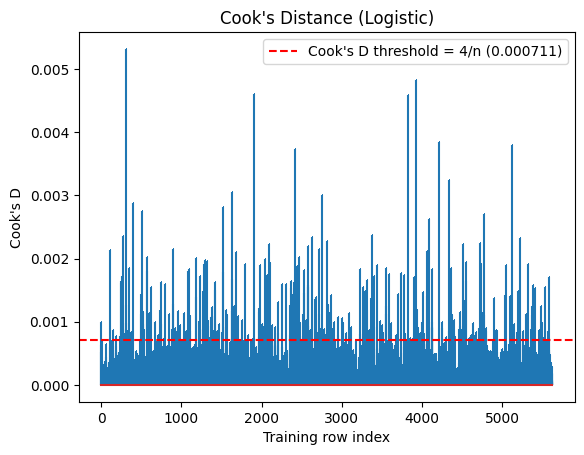

In [268]:
influence = logit_res.get_influence()
summary_frame = influence.summary_frame()

n = len(y_train)
thr = 4 / n

# Cook's Distance plot
summary_frame["cooks_d"] = influence.cooks_distance[0]
plt.stem(summary_frame["cooks_d"], markerfmt=",")
plt.axhline(thr, ls="--", color="r", label=f"Cook's D threshold = 4/n ({thr:.6f})")
plt.title("Cook's Distance (Logistic)")
plt.xlabel("Training row index")
plt.ylabel("Cook's D")
plt.legend()
plt.show()

> We use a Cook's Distance plot to identify outliers. The plot indicates no highly influential points. While we see many of the points are above the Cook's threshold line on the plot, the maximum Cook's D is around 0.006, which is still tiny, so we can believe that our data does not hae any strongly influential outliers

# (4) Generalized Additive Model

In [269]:
# this was my first time using a GAM, so talked with chatGPT about the different types of GAMs
# it recommended logisticGAM since we have a binary Y
gam = LogisticGAM().gridsearch(X_train.values, y_train.values)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:08 ETA:   0:01:27
 18% (2 of 11) |####                     | Elapsed Time: 0:00:09 ETA:   0:00:44
 27% (3 of 11) |######                   | Elapsed Time: 0:00:10 ETA:   0:00:28
 36% (4 of 11) |#########                | Elapsed Time: 0:00:11 ETA:   0:00:20
 45% (5 of 11) |###########              | Elapsed Time: 0:00:14 ETA:   0:00:17
 54% (6 of 11) |#############            | Elapsed Time: 0:00:15 ETA:   0:00:13
 63% (7 of 11) |###############          | Elapsed Time: 0:00:16 ETA:   0:00:09
 72% (8 of 11) |##################       | Elapsed Time: 0:00:17 ETA:   0:00:06
 81% (9 of 11) |####################     | Elapsed Time: 0:00:18 ETA:   0:00:04
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:19 ETA:   0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


In [270]:
# Referenced Dr. Bent's generalized-models-interpretability.ipynb notebook
# Make predictions
y_pred_gam = gam.predict(X_test)

# Calculate MSE and R^2
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam)

# Dr. Bent uses R2 in her notebook but she uses Linear GAM and I am using logistic GAM so I dont think it is appropriate here
# print(f"GAM MSE: {mse_gam:.4f}, R^2: {r2_gam:.4f}")

gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      34.203
Link Function:                        LogitLink Log Likelihood:                                 -2262.2437
Number of Samples:                         5625 AIC:                                             4592.8933
                                                AICc:                                            4593.3494
                                                UBRE:                                               2.8214
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3054
Feature Function                  Lam

/var/folders/bs/tlrmg2n164520pry59rs7fvh0000gn/T/ipykernel_62034/392903951.py:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


> The GAM explains about 30% of the deviance based on the pseudo-Rsquared of 0.31. Several features exhibit non-linear effects (EDoF > 1), specifically those mapped to s(1), s(2), s(3), s(0). Below we visualize what this actually means in the context of customer churn

### Assessing Accuracy

Accuracy: 0.792 | Precision: 0.643 | Recall: 0.492 | F1: 0.558
ROC AUC: 0.835 | LogLoss: 0.426 
              precision    recall  f1-score   support

           0      0.831     0.901     0.864      1033
           1      0.643     0.492     0.558       374

    accuracy                          0.792      1407
   macro avg      0.737     0.697     0.711      1407
weighted avg      0.781     0.792     0.783      1407



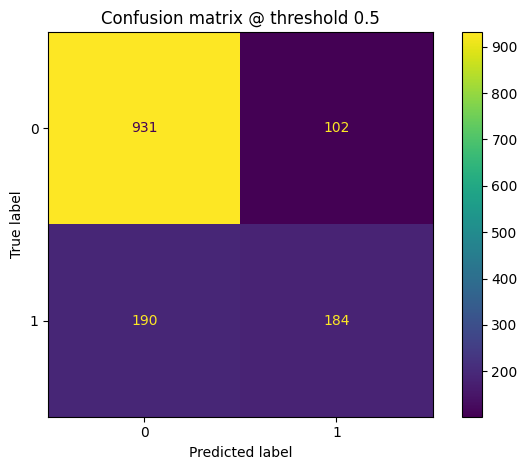

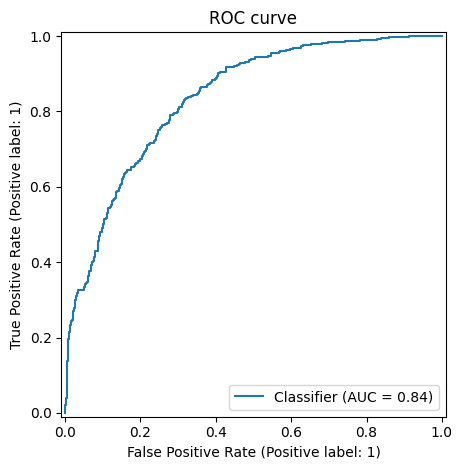

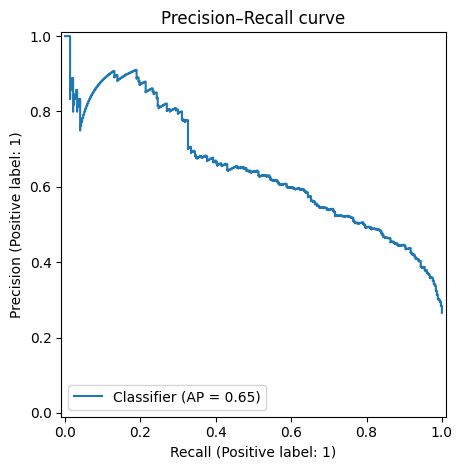

In [271]:
# similar to how we assessed Acc for listic regression
y_pred = gam.predict(X_test)
y_prob = gam.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred_gam)
bacc = balanced_accuracy_score(y_test, y_pred_gam)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_gam, average="binary", zero_division=0
)
auc = roc_auc_score(y_test, y_prob)
ll = log_loss(y_test, y_prob)

print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print(f"ROC AUC: {auc:.3f} | LogLoss: {ll:.3f} ")
print(classification_report(y_test, y_pred, digits=3))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion matrix @ threshold 0.5")
plt.tight_layout()
plt.show()


# ROC and PR curves
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC curve")
plt.tight_layout()
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision–Recall curve")
plt.tight_layout()
plt.show()

> Accuracy Assessment: The GAM earns an ROC AUC of 0.835 which is strong. At the 0.5 threshold, accuracy is 0.792, precision is 0.643, recall is 0.492 and F1 is 0.558. Compared to logistic regression GAM is slightly higher in AUC, log loss and PR-AP. However, GAM trades recall for precision compared to Logistc regression.

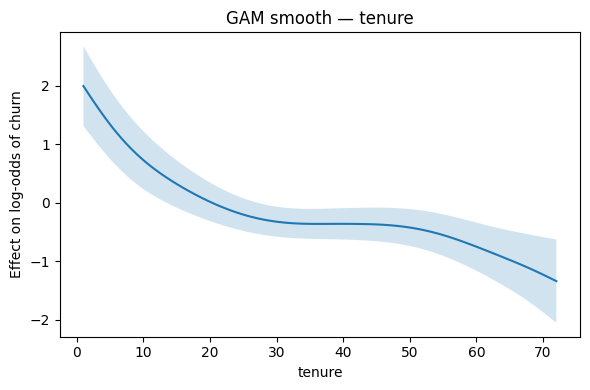

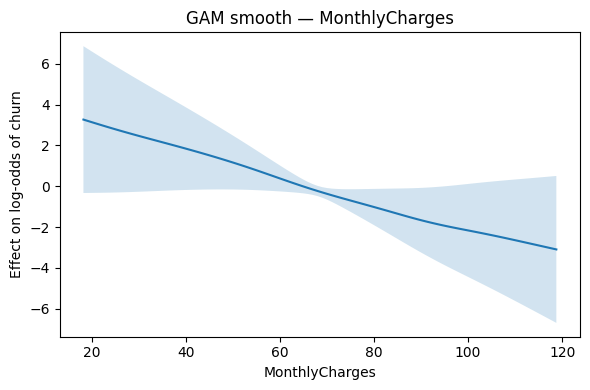

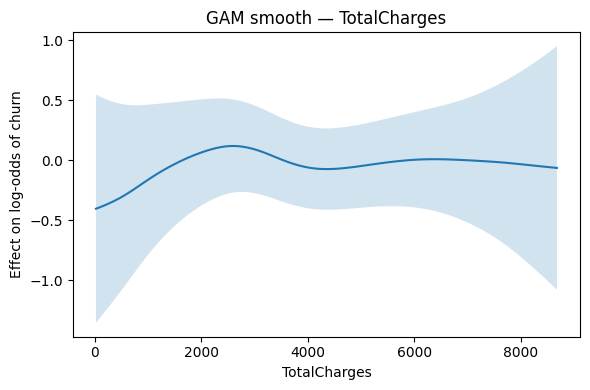

In [272]:
# Adapted Dr. Bent's plotting code from generalized-models-interpretability.ipynb to our case

feature_names = list(X_train.columns)
cont_cols = [c for c in feature_names if X_train[c].nunique() > 10]


def term_index_for_feature(gam, feat_name):
    """Return the term index in gam.terms that corresponds to this feature."""
    feat_idx = feature_names.index(feat_name)
    for j, t in enumerate(gam.terms):
        if getattr(t, "isintercept", False):
            continue
        # s()/l() terms have .feature and tensor terms have .features
        if hasattr(t, "feature") and t.feature == feat_idx:
            return j, feat_idx
        if hasattr(t, "features") and feat_idx in t.features:
            return j, feat_idx
    return None, None  # not found (e.g., feature not modeled)


def plot_smooth(gam, feat):
    j, feat_idx = term_index_for_feature(gam, feat)
    if j is None:
        return
    XX = gam.generate_X_grid(term=j)
    pdp, confi = gam.partial_dependence(term=j, X=XX, width=0.95)
    lo, hi = confi[:, 0], confi[:, 1]
    x = XX[:, feat_idx]

    plt.figure(figsize=(6, 4))
    plt.plot(x, pdp)
    plt.fill_between(x, lo, hi, alpha=0.2)
    plt.xlabel(feat)
    plt.ylabel("Effect on log-odds of churn")
    plt.title(f"GAM smooth — {feat}")
    plt.tight_layout()
    plt.show()


# loop over all continuous features, since I believe we only interested in continuous for these kinds of plots
for feat in cont_cols:
    plot_smooth(gam, feat)

> By looking at the plots, we see the tenure curve drops hard in the first ~20 months and then levels off telling us that earlier customers are much more likely to churn than longer time customers. MonthlyCharges trends downward overall (with wide bands at the very low/high ends), which suggests higher-priced plans churn less once you control for plan/contract mix. TotalCharges are basically flat. 

> GAM Assumptions include: (class slides do not list any assumptions, found these through Google search)
* Right family/link
* Additivity & Smoothness
* Independence of observation

> For Right family/link, we used a LogisticGAM which takes binomial + logit, which is appropriate for our binary outcome of Churn.  For Additivity, from the summary of the GAM, the terms with edf>1 show real non-linear signal. For Independence, because each row of our data represents one customer, we can reasonably assume independence. 

# (5) Model Comparison

Each of the models we assessed has both strengths and weaknesses. Linear Regression stood out as the worst selection, due to its usecase being for predicting continuous outcomes and our usecase being the binary outcome of Churn, as well as it violating almost all assumptions. It is not a good fit for a binary target as it can predict values outside of that binary. Additionally, the model obtained an Rsquared of 0.25, meaning it only explains 25% of the variabiltiy in Churn, which is not very impressive. Linear regression is, however, the most easily interpreted of the 3 models we tested as it is very commonly used and clearly shows how a change in a feature impacts the outcome variable. That being said, it is not appropriate to be used to predict a binary outcome and I dont think should even be considered for the question of interest.  

Logistic regression and Logistic GAM were strong contenders as they are appropriate for use in predicitng binary outcomes. Logistic regression is a solid, interpretable baseline. It delivers clear odd-ratio stories whose interpretations are still relatively easy to understand. As far as accuracy, Logist regression obtained an AUC of 0.832, log loss of 0.432 and at a 0.5 threshold precision/recall/F1 = 0.623/0.516/0.564. GAM adds additional nuance, adding flexible curves for continuous features, like the insight that churn risk drops steeply in the first ~20 months, which was not uncovered by the other models. As far as AUC  (0.835) and log  loss (0.426), GAM slightly outperforms Logistic regression, but at the threshold dependent metrics, GAM trades a bit of recall for precision.  

As far as my recommendation to the client company, due to the performance gap between the two not being drastic, I would recommend using the Logistic regression model. It is much easier to interpret, especially if the audience at the company is not super technical. However, GAM did provide more interesting nuanced insights that Logistic regression alone did not reveal. Logistic Regression can be used for day-to-day reporting, whereas GAM can be used periodically for analytics to audit non-linear pattern in clients

